# Solution of N2 exercise: Handling the log files

In this tutorial, we will learn how to avoid to read directly the logfiles [log.yaml](./log.yaml), [log-LDA.yaml](./log-LDA.yaml), [log-HF.yaml](./log-HF.yaml) and [log-PBE0.yaml](./log-PBE0.yaml) where all information about the calculation are stored.

because the logfile is a serialized python dictionary written in yaml, it is possible using the yaml module to convert it into a python dictionary and process it.

In order to simplify this step, we will use the *Logfile* class which has nice method to extract easily the information. This [tutorial](../notebooks/Logfile-Basics.ipynb) explains the basics of the *Logfile* class.


<h2>Exercise</h2>

Compare the values of the HOMO and HOMO-1 eigenvalues for the LDA and the HF run.
Change the values of the hgrid and crmult to find the converged values.

Note that, both in the LDA and in the HF calculation, a norm-conserving PSP is used.

The results can be compared to all-electron calculations, done with different basis sets, from references (units are eV)
(1) S.&nbsp;Hamel <i>et&nbsp;al.</i> J. Electron Spectrospcopy and Related Phenomena 123 (2002) 345-363 and (2) P.&nbsp;Politzer, F.&nbsp;Abu-Awwad, Theor. Chem. Acc. (1998), 99, 83-87:

eigenvalues          | LDA(1) | HF(1) | HF(2) | (Exp.)
---------------------|--------|-------|-------|-------
3&sigma;<sub>g</sub> | 10.36  | 17.25 | 17.31 | (15.60)
1&pi;<sub>u</sub>    | 11.84  | 16.71 | 17.02 | (16.98)
2&sigma;<sub>u</sub> | 13.41  | 21.25 | 21.08 | (18.78)
 
The results depends, of course, on the precision chosen for the calculation, and of the presence of the pseudopotential.
As it is well-known, the pseudopotential appoximation is however much less severe than the approximation induced by typical XC functionals. We might see that, even in the HF case, the presence of a LDA-based pseudopotential (of rather good quality) does not alter so much the results. 

Here you can find the values from BigDFT calculation using a very good precision (*hgrid=0.3*, *crmult=7.0*). 
Note that 1 ha=27.21138386 eV.

eigenvalues          | LDA    | HF
---------------------|--------|------
3&sigma;<sub>g</sub> | 10.40  | 17.32
1&pi;<sub>u</sub>    | 11.75  | 16.62
2&sigma;<sub>u</sub> | 13.52  | 21.30

How much do these values differ from the calculation with default parameters? Do they converge to a given value?
What is the *correlation* for the N2 molecule in (PSP) LDA?

In [5]:
from BigDFT import Calculators as calc #Import the python modules needed
from BigDFT import Logfiles as lf
from BigDFT import InputActions as A

HtoeV = 27.21138386 #Conversion Hartree to meV


dico = dict()

A.set_atomic_positions(dico,'posinp.xyz')
study = calc.SystemCalculator() #Create a calculator

A.set_xc(dico,'LDA')
LDA = study.run(name="LDA",input=dico,skip=True) #Run the code with the name scheme LDA
A.set_xc(dico,'HF')
HF = study.run(name="HF",input=dico,skip=True) #Run the code with the name scheme HF
A.set_xc(dico,'PBE0')
PBE0 = study.run(name="PBE0",input=dico,skip=True) #Run the code with the name scheme HF

Initialize a Calculator with OMP_NUM_THREADS=2 and command /local/binaries/gfortran-fpe-1.8/install/bin/bigdft
Creating the yaml input file "./LDA.yaml"
Executing command:  /local/binaries/gfortran-fpe-1.8/install/bin/bigdft -n LDA -s Yes
Creating the yaml input file "./HF.yaml"
Executing command:  /local/binaries/gfortran-fpe-1.8/install/bin/bigdft -n HF -s Yes
Creating the yaml input file "./PBE0.yaml"
Executing command:  /local/binaries/gfortran-fpe-1.8/install/bin/bigdft -n PBE0 -s Yes


The variables *first*, *LDA*, *HF* and *PBE0* are instances of the class *BigDFT.Logfiles.Logfile* which contain all information as the total energy.
We should also use directly this call loading the corresponding output file as

In [6]:
PBE0 = lf.Logfile("log-PBE0.yaml")

We compare the values of HOMO-1 and HOMO for LDA and HF.

In [7]:
lda_evals = LDA.evals[0][0]
hf_evals = HF.evals[0][0]
print "LDA",lda_evals[-3:]*HtoeV
print "HF", hf_evals[-3:]*HtoeV

LDA [-11.72069487 -11.72068562 -10.37327265]
HF [-17.31174049 -16.60642809 -16.60642409]


## Modifications of the calculation parameters
Then we do a convergence curve varying *hgrid* which controls the grid step of the Daubechies basis set and *crmult* the extension. The default values are:

In [8]:
print 'hgrids',LDA.log['dft']['hgrids']
print 'rmult',LDA.log['dft']['rmult']

hgrids [0.45, 0.45, 0.45]
rmult [5.0, 8.0]


*hgrids* is an array of 3 values for the x, y, and z direction. A simple scalar can be indicated for the input.
*rmult* is composed into two multiplied factors, one for the coarse grid, and the second one for the fine grid.
We build our script for LDA and run it (on one core, it takes 10 minutes roughly for all calculations).

Todo:
  This part has to be modernized with the new input file syntax and dataset retrieval

In [5]:
Hgrids = [0.45, 0.40, 0.35, 0.30, 0.25]
Crmult = [3.0, 5.0, 7.0, 9.0]
dico = lf.Logfile('LDA.yaml').log #Build the dictionary in order to change it (yaml.load with import yaml could be another way)
dico['dft'] = LDA.log['dft'] #Add the dictionary coming from the logfile (which can be also used as an input file)
log_LDA = {}
emin_LDA = 0.0
for crmult in Crmult:
    log_LDA[crmult] = []
    for hgrid in Hgrids:
        A.set_hgrid(dico,hgrid)
        dico['dft']['rmult'] = [ crmult, 8.0]
        name = "LDA-%4.2f-%04.1f" % (hgrid,crmult)
        log = study.run(name=name,input=dico,skip=True)
        log_LDA[crmult].append( log )
        emin_LDA =min(emin_LDA,log.energy)

Creating from a dictionary the yaml input file "LDA-0.45-03.0.yaml"
Executing command:  /local/deutsch/Forge/BigDFT/build-mpif90/install/bin/bigdft -n LDA-0.45-03.0 -s Yes
Creating from a dictionary the yaml input file "LDA-0.40-03.0.yaml"
Executing command:  /local/deutsch/Forge/BigDFT/build-mpif90/install/bin/bigdft -n LDA-0.40-03.0 -s Yes
Creating from a dictionary the yaml input file "LDA-0.35-03.0.yaml"
Executing command:  /local/deutsch/Forge/BigDFT/build-mpif90/install/bin/bigdft -n LDA-0.35-03.0 -s Yes
Creating from a dictionary the yaml input file "LDA-0.30-03.0.yaml"
Executing command:  /local/deutsch/Forge/BigDFT/build-mpif90/install/bin/bigdft -n LDA-0.30-03.0 -s Yes
Creating from a dictionary the yaml input file "LDA-0.25-03.0.yaml"
Executing command:  /local/deutsch/Forge/BigDFT/build-mpif90/install/bin/bigdft -n LDA-0.25-03.0 -s Yes
Creating from a dictionary the yaml input file "LDA-0.45-05.0.yaml"
Executing command:  /local/deutsch/Forge/BigDFT/build-mpif90/install/bin

We do the same loops to run the Hartree-Fock calculations.

In [6]:
dico = lf.Logfile('HF.yaml').log #Build the dictionary in order to change it (yaml.load with import yaml could be another way)
dico['dft'] = HF.log['dft'] #Add the dictionary coming from the logfile (which can be also used as an input file)
log_HF = {}
emin_HF = 0.0
for crmult in Crmult:
    log_HF[crmult] = []
    for hgrid in Hgrids:
        dico['dft']['hgrids'] = hgrid
        dico['dft']['rmult'] = [ crmult, 8.0]
        name = "HF-%4.2f-%04.1f" % (hgrid,crmult)
        log = study.run(name=name,input=dico,skip=True)
        log_HF[crmult].append(log)
        emin_HF = min(emin_HF,log.energy)

Creating from a dictionary the yaml input file "HF-0.45-03.0.yaml"
Executing command:  /local/deutsch/Forge/BigDFT/build-mpif90/install/bin/bigdft -n HF-0.45-03.0 -s Yes
Creating from a dictionary the yaml input file "HF-0.40-03.0.yaml"
Executing command:  /local/deutsch/Forge/BigDFT/build-mpif90/install/bin/bigdft -n HF-0.40-03.0 -s Yes
Creating from a dictionary the yaml input file "HF-0.35-03.0.yaml"
Executing command:  /local/deutsch/Forge/BigDFT/build-mpif90/install/bin/bigdft -n HF-0.35-03.0 -s Yes
Creating from a dictionary the yaml input file "HF-0.30-03.0.yaml"
Executing command:  /local/deutsch/Forge/BigDFT/build-mpif90/install/bin/bigdft -n HF-0.30-03.0 -s Yes
Creating from a dictionary the yaml input file "HF-0.25-03.0.yaml"
Executing command:  /local/deutsch/Forge/BigDFT/build-mpif90/install/bin/bigdft -n HF-0.25-03.0 -s Yes
Creating from a dictionary the yaml input file "HF-0.45-05.0.yaml"
Executing command:  /local/deutsch/Forge/BigDFT/build-mpif90/install/bin/bigdft -n 

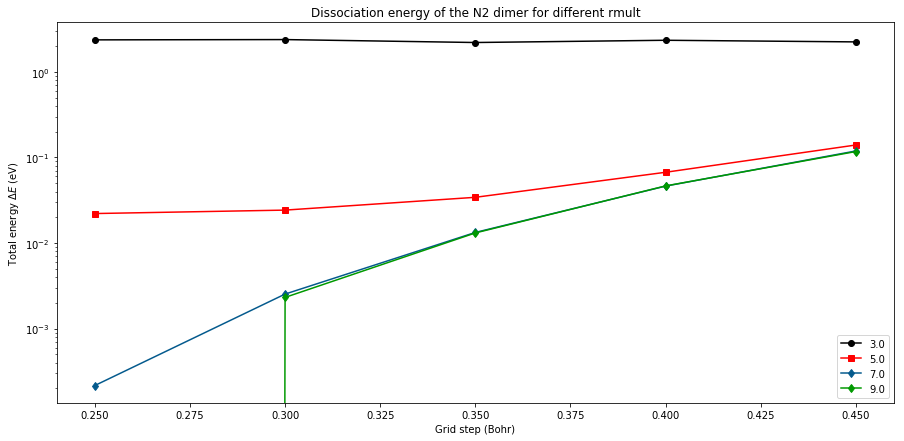

In [7]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
# Lists of markers and colors (for matplotlib)
colors = ['#74a9cf', '#2b8cbe', '#045a8d', '#009900', '#FF8000']
colors = ['#000000', '#ff0000', '#045a8d', '#009900', '#FF8000']
markers = ['o','s','d','d','d']

plt.figure(figsize=(15,7))
# Plot with matplotlib
for i,crmult in enumerate(Crmult):
    im = i%len(colors)
    ener = [ HtoeV*(l.energy-emin_LDA) for l in log_LDA[crmult] ]
    plt.plot(Hgrids, ener, marker=markers[im], 
             ls='-', label=str(crmult),color=colors[im])  

plt.yscale('log')
plt.xlabel('Grid step (Bohr)')
plt.ylabel('Total energy $\Delta E$ (eV)')
plt.title('Dissociation energy of the N2 dimer for different rmult')
plt.legend(loc=4)
plt.show()

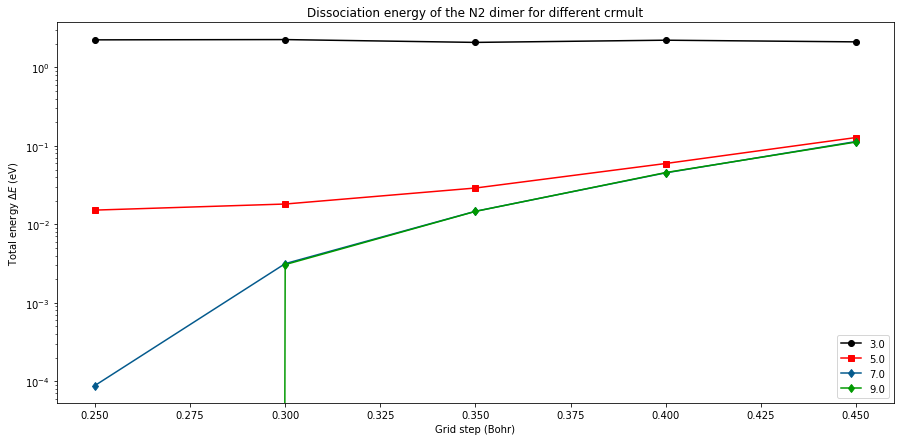

In [8]:
plt.figure(figsize=(15,7))
# Plot with matplotlib
for i,crmult in enumerate(Crmult):
    im = i%len(colors)
    ener = [ HtoeV*(l.energy-emin_HF) for l in log_HF[crmult] ]
    plt.plot(Hgrids, ener, marker=markers[im], 
             ls='-', label=str(crmult),color=colors[im])  

plt.yscale('log')
plt.xlabel('Grid step (Bohr)')
plt.ylabel('Total energy $\Delta E$ (eV)')
plt.title('Dissociation energy of the N2 dimer for different crmult')
plt.legend(loc=4)
plt.show()

In order to converge the result, you need to decrease the grid step and also increase the extension of the mesh. For a given *crmult*, the curve are almost flat. For a *hgrid* value of of 0.35, there is few difference between the values with *crmult*=5.0 and 7.0 but for a *hgrid* value of 0.20 it is important. Now we give the HOMO-1 and HOMO eigenvalues both for LDA and HF functionals

In [9]:
ih = Hgrids.index(0.3)
lda_evals = log_LDA[7.0][ih].evals[0][0]
hf_evals = log_HF[7.0][ih].evals[0][0]
print "LDA   HF"
for (l,h) in zip(reversed(lda_evals),reversed(hf_evals)):
    print "%5.2f %5.2f" % (-HtoeV*l, -HtoeV*h)

LDA   HF
10.40 16.63
11.75 16.63
11.75 17.32
13.52 21.30
28.08 39.83
